### Libraries

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Processing Dataset

In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(ds_path = "ferdousi.txt"):
    print("Reading lines...")
    input_lang = Lang('lang1')
    output_lang = Lang('lang1')
    input_lines = []
    target_lines = []
    sentences = []
    lastLine = 'test'
    i=0
    with open(ds_path) as f:
      for line in f.readlines():
        i+=1
        if(i>=3):
          if((i % 4 ==0 or i % 4 ==2 )and i<99220):
            input_lines.append(lastLine.split('\n')[0] +" / "+line.split('\n')[0])
            input_lang.addSentence(lastLine.split('\n')[0] +" / "+line.split('\n')[0])
          if((i % 4 ==0 or i % 4 ==2 )and i>4):
            target_lines.append(lastLine.split('\n')[0] +" / "+line.split('\n')[0])
            output_lang.addSentence(lastLine.split('\n')[0] +" / "+line.split('\n')[0])
          lastLine = line
      for i in range(len(input_lines)):
        sentences.append((input_lines[i],target_lines[i]))
    return input_lang,output_lang,input_lines,target_lines,sentences

In [ ]:
input_lang,output_lang,input_lines,target_lines,sentences= readLangs()
input_len = [len(input_lines[i]) for i in range(len(input_lines))]
out_len = [len(target_lines[i]) for i in range(len(target_lines))]
max_len = max(max(input_len),max(out_len))
print(input_lines[0])
print(target_lines[0])


Reading lines...
به نام خداوند جان و خرد / کزین برتر اندیشه برنگذرد
خداوند نام و خداوند جای / خداوند روزی ده رهنمای


### Encoder & Decoder for GRU

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, h):
        embedded = self.embedding(x).view(1, 1, -1)
        output, hidden = self.gru(embedded, h)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, h)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training and Evalutaing

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    SOS_token = 0
    EOS_token = 1
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length , mode='GRU'):
    SOS_token = 0
    EOS_token = 1
    encoder_hidden = encoder.initHidden()
    if(mode == 'LSTM'):
      encoder_hidden = (encoder.initHidden(), torch.zeros_like(encoder.initHidden()))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    acc = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            acc = acc+1 if torch.argmax(decoder_output) == target_tensor[di] else acc
            decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length , acc / target_length


In [ ]:
def trainIters(pairs, encoder, decoder, input_lang , output_lang, max_length, print_every=5000, learning_rate=0.025 , mode='GRU'):
    n_iters = 75000
    plot_losses = []
    plot_acc = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_acc_total = 0
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    iter = 0 
    for train_sen in pairs:
        input_tensor = tensorFromSentence(input_lang, train_sen[0])
        target_tensor = tensorFromSentence(output_lang, train_sen[1])

        loss , acc = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion, max_length,mode)
        print_loss_total += loss
        plot_loss_total += loss
        print_acc_total += acc
        if iter % print_every == 0 and iter!=0 :
            print_loss_avg = print_loss_total / print_every
            print_acc_avg = print_acc_total / print_every
            print_loss_total = 0
            print_acc_total = 0
            plot_losses.append(print_loss_avg)
            plot_acc.append(print_acc_avg)
            print("in iteration ",iter," of ",len(pairs),"       Average Loss= ",print_loss_avg, "       Average Accuracy= ",print_acc_avg)
        iter+=1
    return plot_acc , plot_losses


In [ ]:
def evaluate(input_lang , encoder, decoder, sentence, max_length , mode = 'GRU'):
    SOS_token = 0
    EOS_token = 1
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        if(mode == 'LSTM'):
          encoder_hidden = (encoder.initHidden(), torch.zeros_like(encoder.initHidden()))

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def find_for_val(validation_data ,encoder ,decoder ,input_lang ,max_length , mode ='GRU'):
  acc = 0
  for i in range(len(validation_data)):
    count = 0
    predict = evaluate(input_lang , encoder, decoder, validation_data[i][0], max_length,mode)
    seq1 = validation_data[i][1].split(" ")
    seq2 = (" ").join(predict[:-1]).split(" ")
    for i in range(min(len(seq1),len(seq2))):
      if(seq1[i]!=seq2[i]):
        #print(seq1[i])
        #print(seq2[i])
        count+=1
    count += abs(len(seq1) - len(seq2))
    count /= max(len(seq1),len(seq2))
    acc += 1 - count
  return acc/len(validation_data)


### Training for GRU

In [ ]:
hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [ ]:
train_size = int(len(sentences)*0.9)
Val_test_size = int(len(sentences)*0.1)

In [ ]:
len(sentences[train_size:])

4961

In [ ]:
loss = []
acc = []
acc_val = []
epochs = 5
for epoch in range(epochs):
        try:
          print("#################################### EPOCH number ",epoch)
          plot_acc , plot_losses = trainIters(sentences[:train_size], encoder1, decoder1,
                                            input_lang, output_lang , max_len, print_every=5000, learning_rate=0.001)
          val = find_for_val(sentences[train_size:] ,encoder1 ,decoder1 ,input_lang ,max_len)
          print("Validation Accuracy= ",val)
          loss.append(plot_losses)
          acc.append(plot_acc)
          acc_val.append(val)

        except KeyboardInterrupt:
          break




#################################### EPOCH number  0
in iteration  5000  of  44647        Average Loss=  6.150337399468703        Average Accuracy=  0.18414704378267022
in iteration  10000  of  44647        Average Loss=  5.574740184562325        Average Accuracy=  0.21404906412816668
in iteration  15000  of  44647        Average Loss=  5.452487425471579        Average Accuracy=  0.23052634711951378
in iteration  20000  of  44647        Average Loss=  5.553909120126435        Average Accuracy=  0.23379113070881863
in iteration  25000  of  44647        Average Loss=  5.540816990352374        Average Accuracy=  0.23718629051547285
in iteration  30000  of  44647        Average Loss=  5.3799818783724875        Average Accuracy=  0.24217828257398125
in iteration  35000  of  44647        Average Loss=  5.405989183653317        Average Accuracy=  0.2464695615151994
in iteration  40000  of  44647        Average Loss=  5.482932370008991        Average Accuracy=  0.2535329112365139
Validation Ac

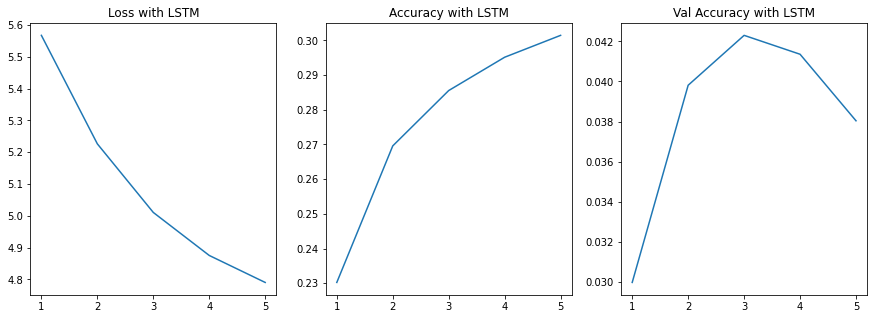

In [39]:
import numpy as np
import matplotlib.pyplot as plt
loss11 = [np.mean(np.array(loss[i])) for i in range(len(loss))]
acc11 = [np.mean(np.array(acc[i])) for i in range(len(acc))]
acc_val11 = [np.mean(np.array(acc_val[i])) for i in range(len(acc_val))]
X = [1,2,3,4,5] 
  
# create figure
fig = plt.figure(figsize=(15, 5))
  
# setting values to rows and column variables
rows = 1
columns = 3

  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.plot(X, loss11)

plt.title("Loss with LSTM")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.plot(X, acc11)

plt.title("Accuracy with LSTM")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.plot(X, acc_val11)

plt.title("Val Accuracy with LSTM")
 
plt.show()

In [ ]:
random_verse = random.choices(range(len(sentences)), k=10)
for i, index in enumerate(random_verse):
    predicted = evaluate(input_lang , encoder1, decoder1, sentences[index][0], max_len)
    print('\n########################################\n')
    print('input verse:')
    print(sentences[index][0])
    print('output seconde verse:')
    print(" ".join(predicted[:-1]))
    print('real seconde  verse:')
    print(sentences[index][1])


########################################

first verse:
چو شوید بعنبر شب تیره روی / بیفشاند این گیسوی مشکبوی
generated seconde verse:
چو بهرام خسرو چو گستهم / چو آمد به نزدیک خسرو رسید
real seconde  verse:
شما برنشینید با ساز جنگ / همه گرز و خنجر گرفته بچنگ

########################################

first verse:
پر از درد ازان باره آمد فرود / همی داد تخت مهی را درود
generated seconde verse:
بدو گفت خسرو که ای شهریار / که از تخم با من به یزدان شناس
real seconde  verse:
همی گفت کی بینمت نیز باز / ایاروز شادی و آرام و ناز

########################################

first verse:
چو جفت من آید به نزدیک تو / درخشان کند جان تاریک تو
generated seconde verse:
بدو گفت خسرو که ای شهریار / که از تخم با من به دل روزگار
real seconde  verse:
ز گفتار او هیچ گونه مگرد / چو گردی شود بخت را روی زرد

########################################

first verse:
ز ترکان دو بهره بپای ستور / سپردند و شد بخت را آب شور
generated seconde verse:
چو خسرو بیامد ز خسرو سپاه / که بودند زان پس به راه
real seconde  verse:
هنو

### Encoder & Deccoder for LSTM

In [ ]:
class EncoderRNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, x, h):
        embedded = self.embedding(x).view(1, 1, -1)
        output, hidden = self.lstm(embedded, h)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
class DecoderRNNLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, h)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training for LSTM

In [ ]:
hidden_size = 100
encoder2 = EncoderRNNLSTM(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNNLSTM(hidden_size, output_lang.n_words).to(device)

In [19]:
loss2 = []
acc2 = []
acc_val2 = []
epochs = 5
for epoch in range(epochs):
    try:
        print("#################################### EPOCH number ",epoch)
        plot_acc , plot_losses = trainIters(sentences[:train_size], encoder2, decoder2, input_lang, output_lang , max_len, print_every=5000, learning_rate=0.001,mode='LSTM')
        val = find_for_val(sentences[train_size:] ,encoder2 ,decoder2 ,input_lang ,max_len , mode='LSTM')
        print("Validation Accuracy= ",val)
        loss2.append(plot_losses)
        acc2.append(plot_acc)
        acc_val2.append(val)
    except KeyboardInterrupt:
        break

#################################### EPOCH number  0
in iteration  5000  of  44647        Average Loss=  6.172221466859733        Average Accuracy=  0.18094372697048366
in iteration  10000  of  44647        Average Loss=  5.615169421793191        Average Accuracy=  0.20784227425996782
in iteration  15000  of  44647        Average Loss=  5.5279204402836735        Average Accuracy=  0.22472460633621794
in iteration  20000  of  44647        Average Loss=  5.656456116579537        Average Accuracy=  0.22786762330548818
in iteration  25000  of  44647        Average Loss=  5.672476268946156        Average Accuracy=  0.23173744438825958
in iteration  30000  of  44647        Average Loss=  5.509981532434537        Average Accuracy=  0.23475464600329388
in iteration  35000  of  44647        Average Loss=  5.51948246977646        Average Accuracy=  0.2386796224793468
in iteration  40000  of  44647        Average Loss=  5.616594952031381        Average Accuracy=  0.2464458932381724
Validation Acc

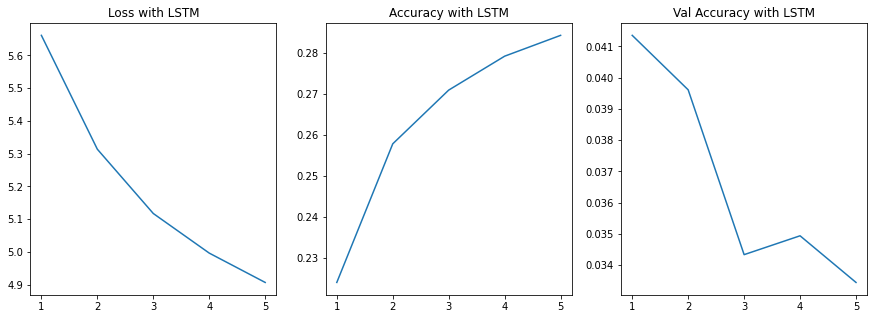

In [38]:
import numpy as np
import matplotlib.pyplot as plt
loss22 = [np.mean(np.array(loss2[i])) for i in range(len(loss2))]
acc22 = [np.mean(np.array(acc2[i])) for i in range(len(acc2))]
acc_val22 = [np.mean(np.array(acc_val2[i])) for i in range(len(acc_val2))]
X = [1,2,3,4,5] 

# create figure
fig = plt.figure(figsize=(15, 5))
  
# setting values to rows and column variables
rows = 1
columns = 3

  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.plot(X, loss22)

plt.title("Loss with LSTM")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.plot(X, acc22)

plt.title("Accuracy with LSTM")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.plot(X, acc_val22)

plt.title("Val Accuracy with LSTM")
 
plt.show()

In [41]:
random_verse = random.choices(range(len(sentences)), k=10)
for i, index in enumerate(random_verse):
    predicted = evaluate(input_lang , encoder2, decoder2, sentences[index][0], max_len , mode='LSTM')
    print('\n########################################\n')
    print('input verse:')
    print(sentences[index][0])
    print('output seconde verse:')
    print(" ".join(predicted[:-1]))
    print('real seconde  verse:')
    print(sentences[index][1])
    


########################################

input verse:
نویسنده پردخته شد ز آفرین / نهاد از بر نامه خسرو نگین
output seconde verse:
چو خسرو چنین گفت بهرام را / که ای نامداران و با سپاه
real seconde  verse:
بفرمود تا خلعت آراستند / ستام و کمرها بپیراستند

########################################

input verse:
چنین جامه پوشید کز شرم شاه / نیارست کردن به رویش نگاه
output seconde verse:
چو بهرام خسرو ز لشکر نگفت / که از نامداران و با سپاه جفت
real seconde  verse:
برادر گر از تو بپوشید روی / ز شرم توبود آن بهانه مجوی

########################################

input verse:
چو لهاک جنگی و فرشیدورد / ابا سی هزار از دلیران مرد
output seconde verse:
چو خسرو چنین گفت بهرام را / که ای نامداران و با سپاه
real seconde  verse:
گرفتند بر میمنه جایگاه / جهان سربسر گشت ز آهن سیاه

########################################

input verse:
یکی پاسخ نامه بنوشت و گفت / که با جان پاکان خرد باد جفت
output seconde verse:
چو خسرو چنین گفت خسرو که ای / که ای نامداران و با فرهی
real seconde  verse:
بدان بازگشتیم همد